# Kaggle設置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read env var
!pip install python-dotenv
import dotenv
import os

dotenv.load_dotenv("/content/drive/MyDrive/中興_人工智慧概論/HW_final/.env")
api_token = {"username":os.getenv("KAGGLE_USERNAME"),"key":os.getenv("KAGGLE_KEY")}

!pip install kaggle

import json

kaggle_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_path, exist_ok=True)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(api_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

In [ ]:
api_token["username"]

'johnnydo0730'

# 觀察模型

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Trainable params:", np.sum([np.prod(v.shape) for v in base_model.trainable_weights]))

#base_model.trainable = False
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Trainable params: 20024384
  0 | input_layer                              | trainable = True
  1 | block1_conv1                             | trainable = True
  2 | block1_conv2                             | trainable = True
  3 | block1_pool                              | trainable = True
  4 | block2_conv1                             | trainable = True
  5 | block2_conv2                             | trainable = True
  6 | block2_pool                              | trainable = True
  7 | block3_conv1                             | trainable = True
  8 | block3_conv2                             | trainable = True
  9 | block3_conv3                             | trainable = True
 10 | block3_conv4                             | trainable = True
 11 | block3_pool                              | trainable = True
 12 | block4_conv1                             | trainable = True
 13 | block4_conv2                             | trainable = Tru

# 定義訓練流程之通用函數

## 載入套件

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# use the model you want
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

#from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.applications.efficientnet import preprocess_input

## 定義Dataloader

In [ ]:
def get_dataloader(train_dir, preprocess_input=None, img_size=(224, 224), batch_size=32):

  # 定義dataloader，使用資料增強（Data Augmentation）
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,  # 隨機錯切
      zoom_range=0.2,   # 隨機縮放
      horizontal_flip=True,  # 水平翻轉
      rotation_range=20,  # 隨機旋轉
      fill_mode='nearest',  # 填補模式
      validation_split=0.2
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical', # categorical
      subset='training'
  )

  val_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, val_generator


## 定義與編譯模型架構

| 模型             | 特徵圖輸出形狀 (before GAP) | GAP後形狀 (Dense輸入) |
| -------------- | -------------------- | ---------------- |
| VGG19          | (7, 7, 512)          | (512,)           |
| ResNet50       | (7, 7, 2048)         | (2048,)          |
| EfficientNetB0 | (7, 7, 1280)         | (1280,)          |


In [ ]:

def build_model_with_head(base_model, num_classes):
    """
    接收一個 base_model 並接上分類頭，回傳已編譯的模型。

    參數：
        base_model: 已經定義好輸入的預訓練模型（如 VGG19、ResNet50、EfficientNet）
        num_classes: 分類數（1 代表二分類，多類分類請傳整數 >1）
        activation: 最後一層的 activation 函數，二分類用 'sigmoid'，多類用 'softmax'
        loss: 損失函數名稱 (sparse_categorical_crossentropy)

    回傳：
        尚未編譯的 keras.Model（需由使用者自行 compile）
    """

    if num_classes < 1:
      raise ValueError("num_classes 必須 >= 1")

    #activation = 'sigmoid' if num_classes == 1 else 'softmax'
    activation = 'softmax'

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output_tensor = layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_tensor)

    return model

## callback tools

In [ ]:
import pickle
import os

class HistorySaver(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
'''
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
'''

"\nlr_scheduler = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.5,\n    patience=2,\n    min_lr=1e-7,\n    verbose=1\n)\n"

## 定義訓練函數

In [ ]:
def train_model_with_gpu_check(model, train_generator, val_generator, lr, epochs, save_dir, phase, lr_scheduler=None):
    """
    檢查 GPU 可用性並訓練模型，儲存最佳模型。

    參數：
        model: 已經編譯好的模型。
        train_generator: 訓練數據生成器（如 ImageDataGenerator 生成器）。
        val_generator: 驗證數據生成器（如 ImageDataGenerator 生成器）。
        epochs: 訓練的輪數（預設為 5）。
        save_dir: 儲存模型的資料夾（預設為 'models'）。
        phase: 訓練階段（'phase1' 或 'phase2'）

    回傳：
        history: 訓練過程的歷史紀錄。
    """

    # 檢查是否有可用的 GPU
    gpus = tf.config.list_physical_devices('GPU')
    #if len(gpus) == 0:
        #raise Exception("No GPU available, stop traing process")
    print("Num GPUs Available: ", len(gpus))

    #loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

    # 設定儲存中間資訊
    checkpoint = ModelCheckpoint(os.path.join(save_dir, phase + '_best_model.keras'), monitor='val_loss', save_best_only=True)
    history_saver = HistorySaver(os.path.join(save_dir, phase + '_history.pkl'))

    # 預設 learning rate scheduler
    callbacks = [checkpoint, history_saver]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)

    # 訓練模型
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

## 視覺化呈現

In [ ]:
def plot_learning_curve_with_split(history, save_dir, phase):
    """
    根據 keras 的 history 物件繪製並儲存學習曲線。
    儲存三張圖：合併版、acc 單獨圖、loss 單獨圖。

    參數：
        history: keras.callbacks.History（model.fit() 的回傳結果）
        save_dir: 儲存圖像的資料夾（預設為 'output'）
    """
    os.makedirs(save_dir, exist_ok=True)

    # 1. 合併版
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, phase + '_learning_curve.png'))
    plt.show()

    # 2. Accuracy 單獨
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))
    plt.savefig(os.path.join(save_dir, phase + '_accuracy_curve.png'))
    #plt.show()

    # 3. Loss 單獨
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))
    plt.savefig(os.path.join(save_dir, phase + '_loss_curve.png'))
    #plt.show()


## 保存模型

In [ ]:
import os

def save_model(model, save_dir, filename):
    """
    儲存 Keras 模型為指定格式（支援 .keras 或 .h5）

    參數：
        model: 已訓練的 Keras 模型
        filename: 儲存檔名（預設為 'model.keras'）
        save_dir: 儲存資料夾（預設為 'models'）
    """
    os.makedirs(save_dir, exist_ok=True)
    full_path = os.path.join(save_dir, filename)
    model.save(full_path)
    print(f"✅ 模型已儲存至 {full_path}")


#FER plus

  use phase 3 best

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download subhaditya/fer2013plus
!unzip /content/fer2013plus.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: fer2013plus/fer2013/train/sadness/fer0017536.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017542.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017574.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017577.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017579.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017584.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017610.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017616.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017623.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017633.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017649.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017669.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017671.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017676.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017679.png  
  inflating: fer201

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_FERplus_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_FERplus_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus"

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1
Epoch 1/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 522s 727ms/step - accuracy: 0.3394 - loss: 1.7957 - val_accuracy: 0.6140 - val_loss: 1.1607
Epoch 2/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 470s 600ms/step - accuracy: 0.6137 - loss: 1.1734 - val_accuracy: 0.6558 - val_loss: 0.9996
Epoch 3/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 431s 606ms/step - accuracy: 0.6650 - loss: 0.9837 - val_accuracy: 0.6870 - val_loss: 0.9253
Epoch 4/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 502s 691ms/step - accuracy: 0.7057 - loss: 0.8593 - val_accuracy: 0.7270 - val_loss: 0.7913
Epoch 5/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 435s 597ms/step - accuracy: 0.7328 - loss: 0.7738 - val_accuracy: 0.7476 - val_loss: 0.7335


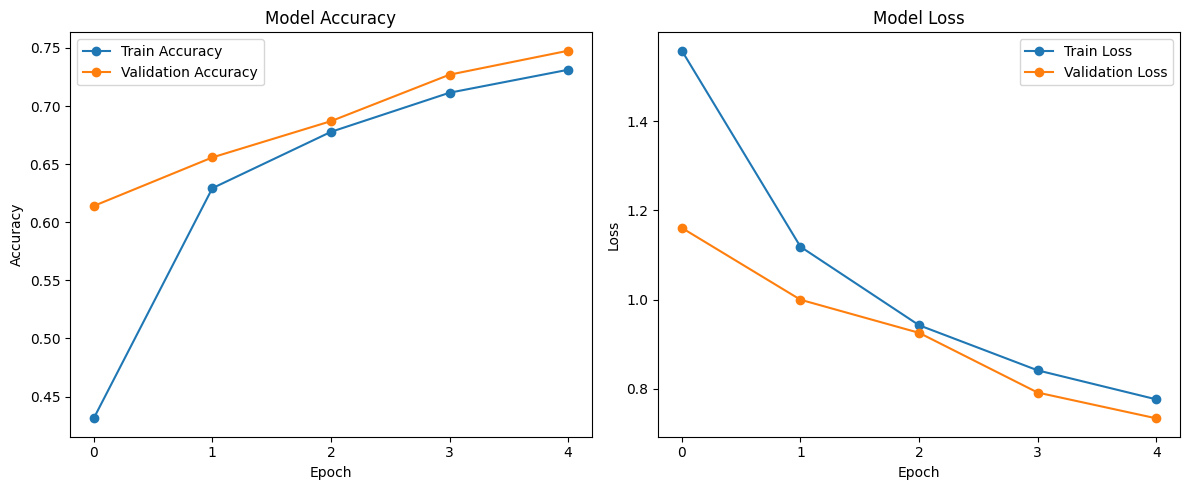

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus/VGG19_FERplus_phase1.keras


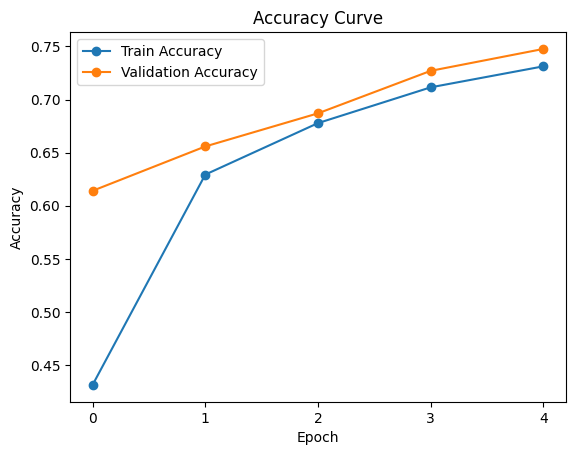

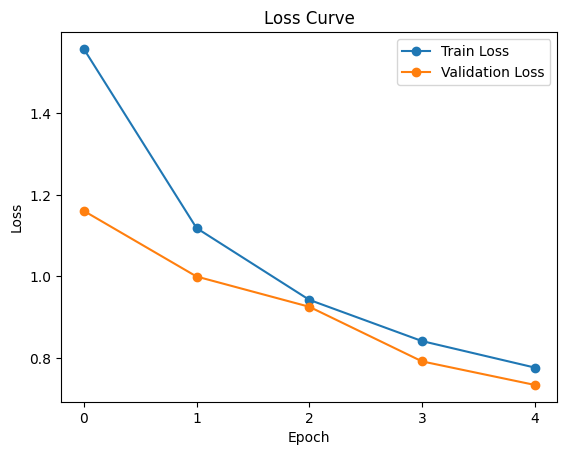

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:17]: # 17 | block5_conv1
    layer.trainable = False
for layer in base_model.layers[17:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_FERplus_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 478s 638ms/step - accuracy: 0.7566 - loss: 0.7002 - val_accuracy: 0.7568 - val_loss: 0.7090 - learning_rate: 1.0000e-05
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 421s 593ms/step - accuracy: 0.7834 - loss: 0.6212 - val_accuracy: 0.7591 - val_loss: 0.6904 - learning_rate: 1.0000e-05
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 428s 603ms/step - accuracy: 0.7918 - loss: 0.6097 - val_accuracy: 0.7615 - val_loss: 0.6755 - learning_rate: 1.0000e-05
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 445s 607ms/step - accuracy: 0.8023 - loss: 0.5710 - val_accuracy: 0.7656 - val_loss: 0.6683 - learning_rate: 1.0000e-05
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 441s 606ms/step - accuracy: 0.8029 - loss: 0.5617 - val_accuracy: 0.7792 - val_loss: 0.6433 - learning_rate: 1.0000e-05
Epoch 6/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 428s 602ms/step - accuracy: 0.8085 - loss: 0.5490 - val_accuracy: 0.7804 - val_loss: 0.6274 - learning_rate: 1.0000e-05
Epoch 7/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 

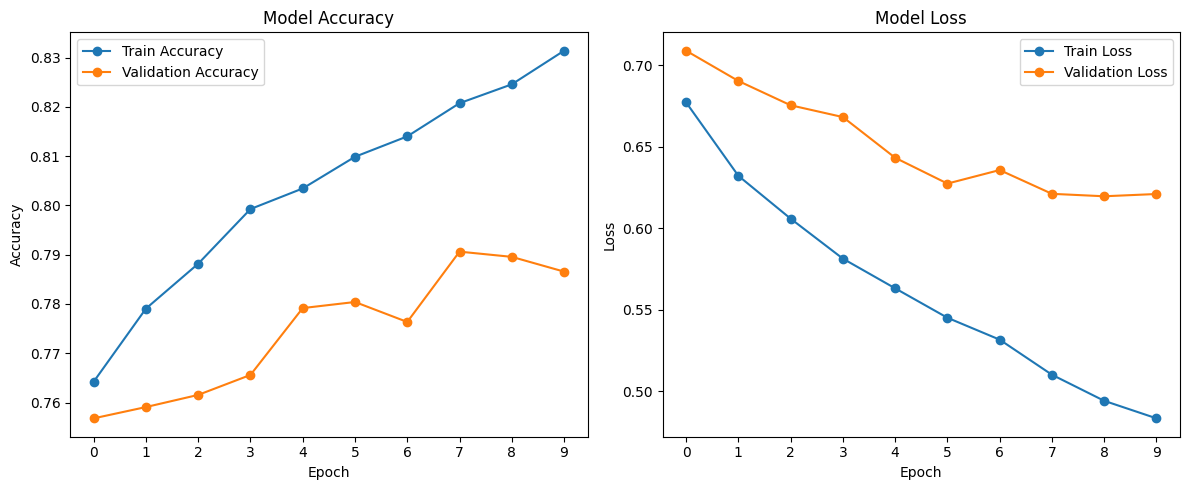

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus/VGG19_FERplus_phase2.keras


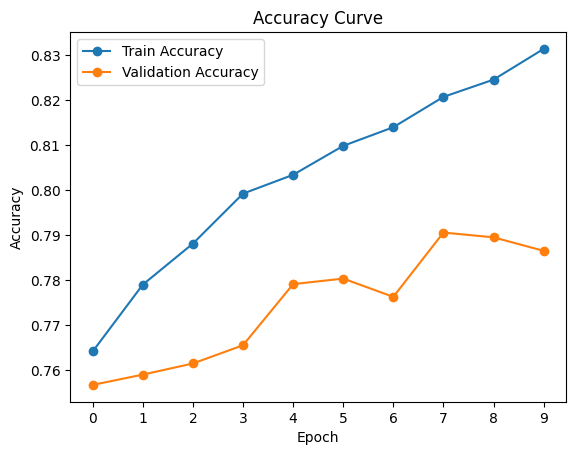

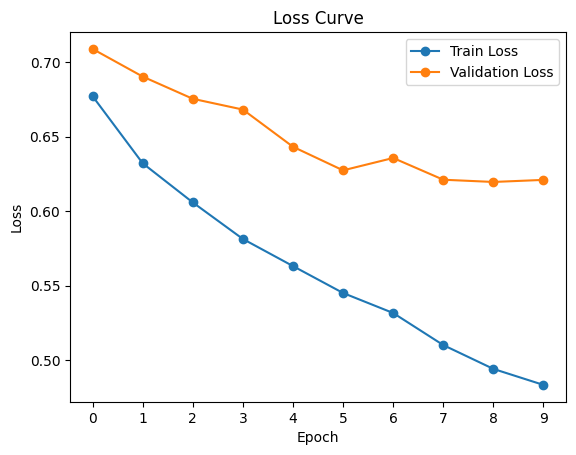

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/VGG19_FERplus_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:12]:  # 12 | block4_conv1
    layer.trainable = False
for layer in model.layers[12:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_FERplus_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 513s 681ms/step - accuracy: 0.8359 - loss: 0.4677 - val_accuracy: 0.7797 - val_loss: 0.6209 - learning_rate: 1.0000e-05
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 449s 632ms/step - accuracy: 0.8412 - loss: 0.4509 - val_accuracy: 0.7811 - val_loss: 0.6370 - learning_rate: 1.0000e-05
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8509 - loss: 0.4323
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
710/710 ━━━━━━━━━━━━━━━━━━━━ 444s 625ms/step - accuracy: 0.8509 - loss: 0.4324 - val_accuracy: 0.7830 - val_loss: 0.6368 - learning_rate: 1.0000e-05
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 442s 622ms/step - accuracy: 0.8565 - loss: 0.4000 - val_accuracy: 0.7982 - val_loss: 0.6213 - learning_rate: 5.0000e-06
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8630 - loss: 0.3820
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
710/710 ━━━━━━━━━━━━━━━━━━━━ 445s 627ms/ste

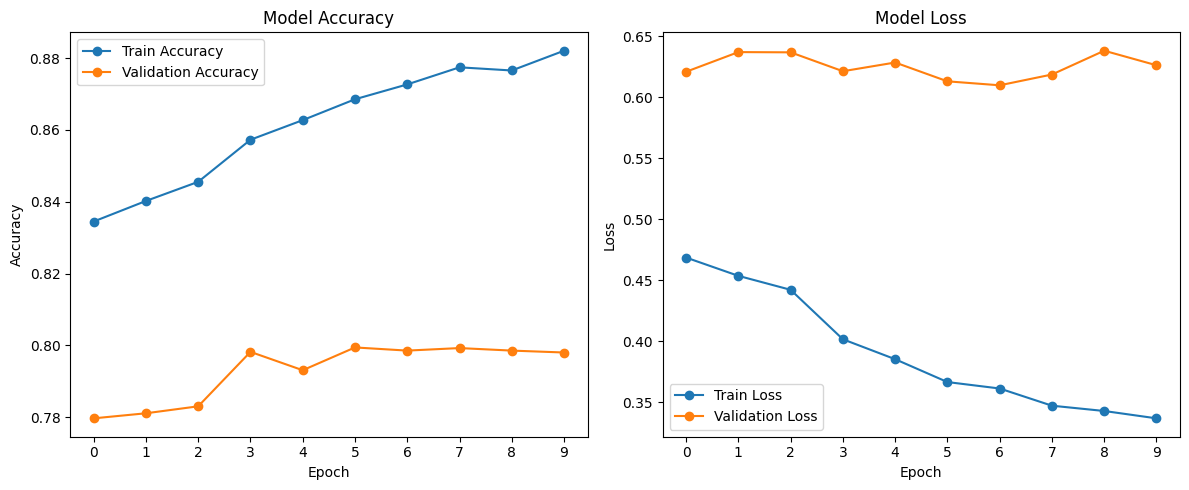

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus/VGG19_FERplus_phase3.keras


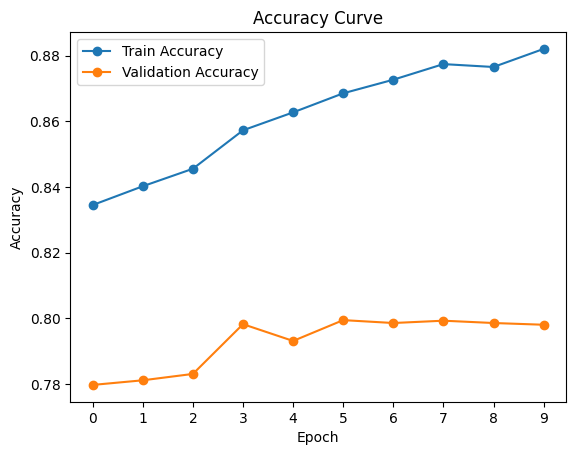

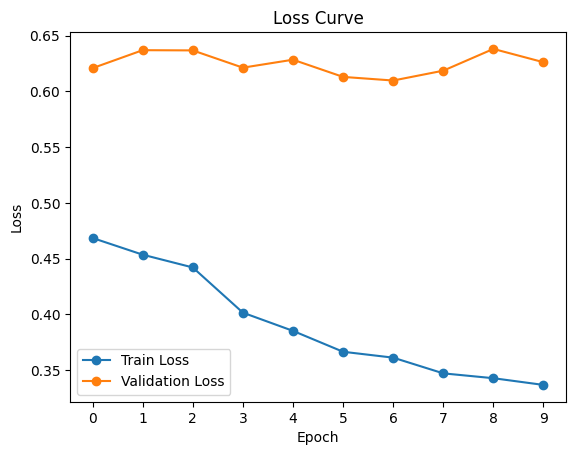

In [ ]:
# phase 3
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/VGG19_FERplus_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:7]:  #  7 | block3_conv1
    layer.trainable = False
for layer in model.layers[7:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_FERplus_" + phase + ".keras")

# RAF-DB


    資料容易過擬合
    ➤ 高解析度 + 彩色照片 + 背景豐富 → 模型易學到非表情特徵（如背景、髮型）

    類別分布不均
    ➤ 快樂、中性樣本佔比極高，導致模型偏向多數類別 → 驗證集上泛化不佳
    
      訓練時模型過度學習多數類別，train acc 較高。
      驗證時少數類別預測失誤，拉低 val acc，造成 gap。

    訓練樣本較少
    ➤ RAF-DB 訓練集樣本比 FER+ 少 → 模型泛化能力下降，容易背誦

    驗證集難度較高
    ➤ 包含更多自然變化（角度、光線） → 驗證表現受影響


    !!! use phase2

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download shuvoalok/raf-db-dataset
!unzip /content/raf-db-dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: DATASET/train/5/train_00987_aligned.jpg  
  inflating: DATASET/train/5/train_00990_aligned.jpg  
  inflating: DATASET/train/5/train_00991_aligned.jpg  
  inflating: DATASET/train/5/train_00992_aligned.jpg  
  inflating: DATASET/train/5/train_01002_aligned.jpg  
  inflating: DATASET/train/5/train_01010_aligned.jpg  
  inflating: DATASET/train/5/train_01011_aligned.jpg  
  inflating: DATASET/train/5/train_01013_aligned.jpg  
  inflating: DATASET/train/5/train_01015_aligned.jpg  
  inflating: DATASET/train/5/train_01017_aligned.jpg  
  inflating: DATASET/train/5/train_01039_aligned.jpg  
  inflating: DATASET/train/5/train_01048_aligned.jpg  
  inflating: DATASET/train/5/train_01049_aligned.jpg  
  inflating: DATASET/train/5/train_01053_aligned.jpg  
  inflating: DATASET/train/5/train_01070_aligned.jpg  
  inflating: DATASET/train/5/train_01074_aligned.jpg  
  inflating: DATASET/train/5/train_01078_aligned.jpg  
  inflating: DATASET/train/5/train_01083_ali

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_RAFDB_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    """
    用來載入訓練資料集並進行資料增強（data augmentation）。

    參數：
        train_dir (str): 訓練資料集的根目錄。
        img_size (tuple): 輸入影像大小。
        batch_size (int): 批次大小。
        validation_split (float): 用來分割訓練資料與驗證資料的比例。

    回傳：
        train_generator: 訓練資料生成器。
        val_generator: 驗證資料生成器。
    """

    # 定義資料增強
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,  # 隨機錯切
        zoom_range=0.2,   # 隨機縮放
        horizontal_flip=True,  # 水平翻轉
        rotation_range=20,  # 隨機旋轉
        fill_mode='nearest',  # 填補模式
        validation_split=validation_split  # 設定驗證集的比例
    )

    # 訓練集生成器
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # 類別模式：多類別分類
        subset='training'  # 設定為訓練集
    )

    # 驗證集生成器
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # 設定為驗證集
    )

    return train_generator, val_generator


In [ ]:
def get_RAFDB_testloader(test_dir, img_size=(224, 224), batch_size=32):
    """
    用來載入測試資料集。

    參數：
        test_dir (str): 測試資料集的根目錄。
        img_size (tuple): 輸入影像大小。
        batch_size (int): 批次大小。

    回傳：
        test_generator: 測試資料生成器。
    """

    # 定義資料增強（此處測試資料集只會預處理，不進行增強）
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # 測試集生成器
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # 類別模式：多類別分類
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 7
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/RAF-DB"

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 210s 626ms/step - accuracy: 0.3077 - loss: 1.9195 - val_accuracy: 0.5118 - val_loss: 1.3757
Epoch 2/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 557ms/step - accuracy: 0.4789 - loss: 1.4307 - val_accuracy: 0.6011 - val_loss: 1.1835
Epoch 3/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 173s 564ms/step - accuracy: 0.5737 - loss: 1.2091 - val_accuracy: 0.6529 - val_loss: 1.0495
Epoch 4/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 175s 569ms/step - accuracy: 0.6388 - loss: 1.0425 - val_accuracy: 0.6970 - val_loss: 0.9110
Epoch 5/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 171s 558ms/step - accuracy: 0.6670 - loss: 0.9635 - val_accuracy: 0.7092 - val_loss: 0.8849


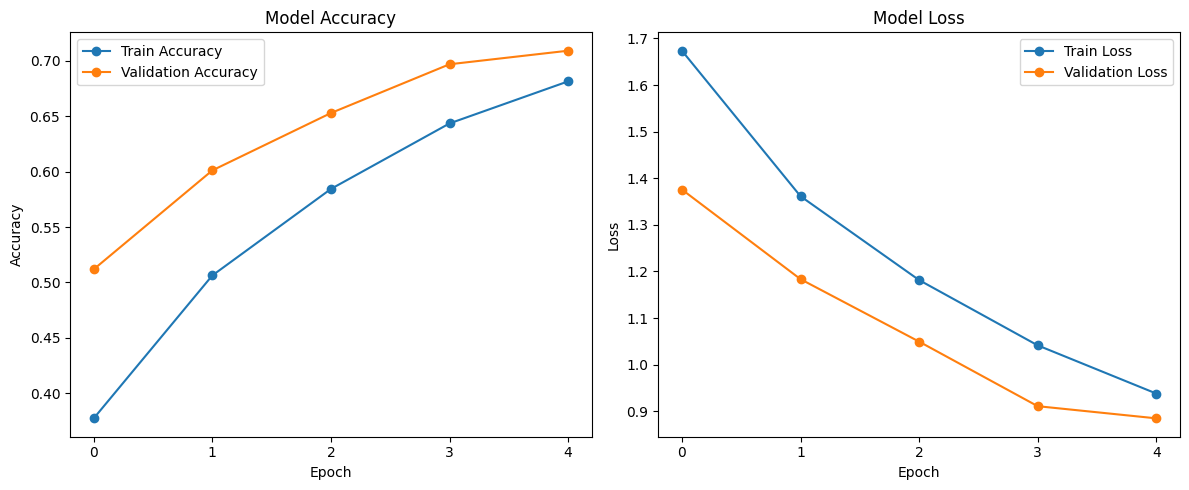

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/RAF-DB/VGG19_RAF-DB_phase1.keras


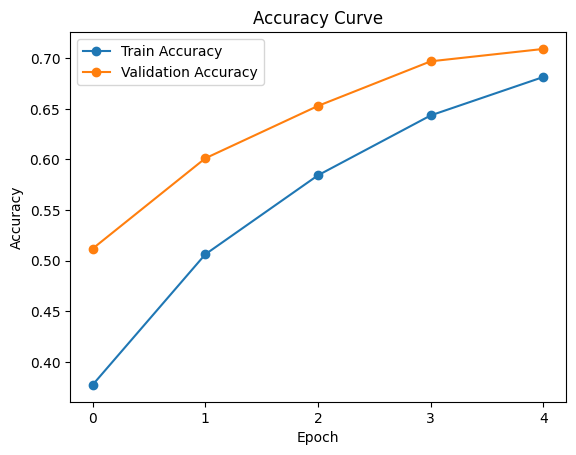

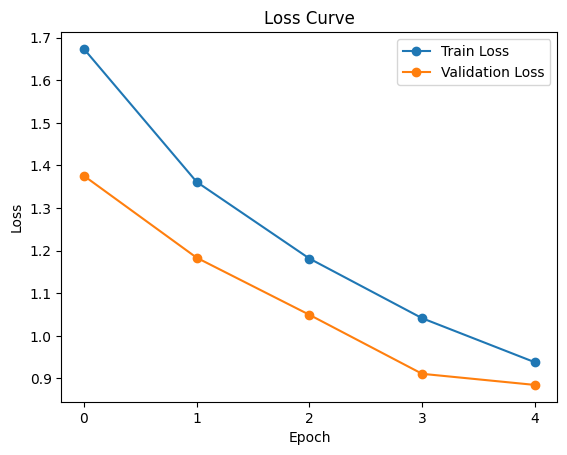

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True
for layer in base_model.layers[:17]: # 17 | block5_conv1
    layer.trainable = False
for layer in base_model.layers[17:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_RAF-DB_" + phase + ".keras")

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 209s 640ms/step - accuracy: 0.7110 - loss: 0.8458 - val_accuracy: 0.7402 - val_loss: 0.7833 - learning_rate: 1.0000e-05
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 187s 609ms/step - accuracy: 0.7369 - loss: 0.7821 - val_accuracy: 0.7325 - val_loss: 0.8065 - learning_rate: 1.0000e-05
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 184s 598ms/step - accuracy: 0.7502 - loss: 0.7349 - val_accuracy: 0.7553 - val_loss: 0.7344 - learning_rate: 1.0000e-05
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 198s 645ms/step - accuracy: 0.7640 - loss: 0.6863 - val_accuracy: 0.7480 - val_loss: 0.7632 - learning_rate: 1.0000e-05
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 193s 628ms/step - accuracy: 0.7772 - loss: 0.6518 - val_accuracy: 0.7557 - val_loss: 0.7219 - learning_rate: 1.0000e-05
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 190s 618ms/step - accuracy: 0.7792 - loss: 0.6481 - v

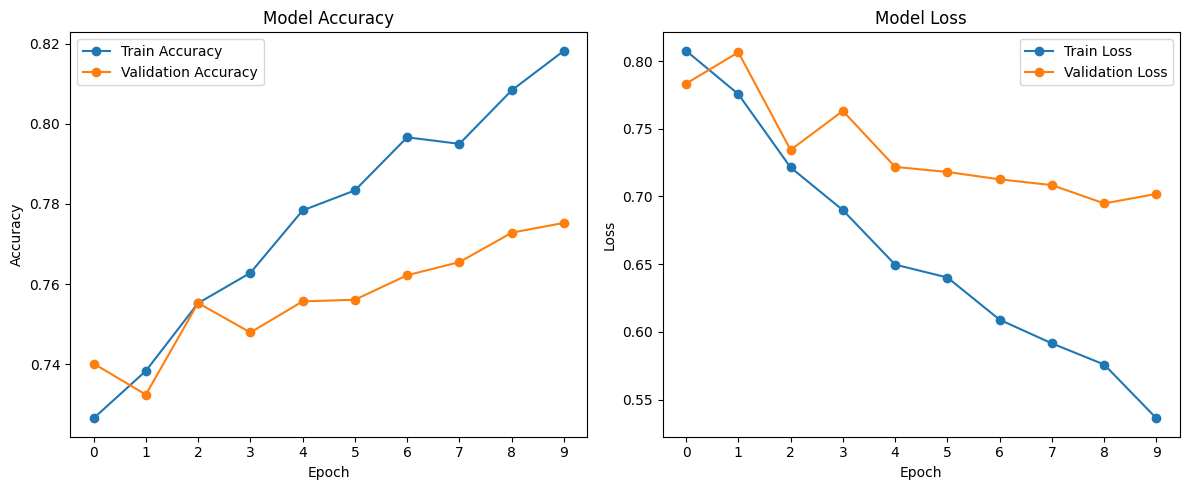

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/RAF-DB/VGG19_RAF-DB_phase2.keras


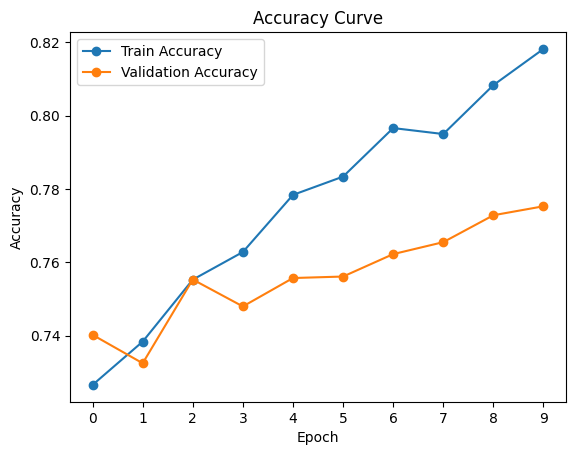

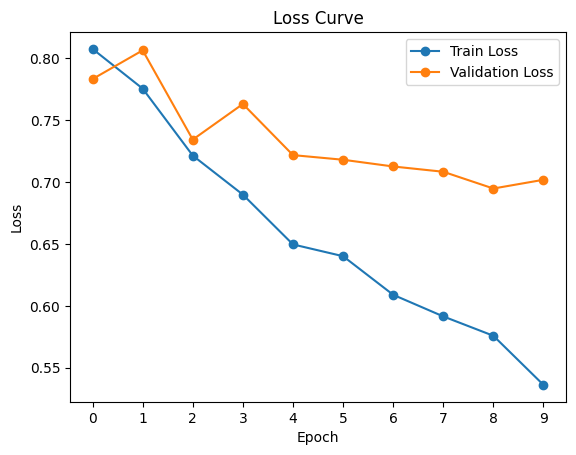

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/VGG19_RAF-DB_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:12]:  # 12 | block4_conv1
    layer.trainable = False
for layer in model.layers[12:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_RAF-DB_" + phase + ".keras")

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 277s 806ms/step - accuracy: 0.8185 - loss: 0.5329 - val_accuracy: 0.7716 - val_loss: 0.7262 - learning_rate: 1.0000e-05
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 207s 674ms/step - accuracy: 0.8273 - loss: 0.5051 - val_accuracy: 0.7565 - val_loss: 0.7577 - learning_rate: 1.0000e-05
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8265 - loss: 0.5081
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
307/307 ━━━━━━━━━━━━━━━━━━━━ 259s 665ms/step - accuracy: 0.8266 - loss: 0.5081 - val_accuracy: 0.7602 - val_loss: 0.7454 - learning_rate: 1.0000e-05
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 206s 669ms/step - accuracy: 0.8550 - loss: 0.4371 - val_accuracy: 0.7785 - val_loss: 0.6813 - learning_rate: 5.0000e-06
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 207s 676ms/step - accuracy: 0.8656 - loss: 0.4005 - val_accuracy: 0.7753 - val_loss: 0.7254 - learning_rate: 5.0000e-06
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 549m

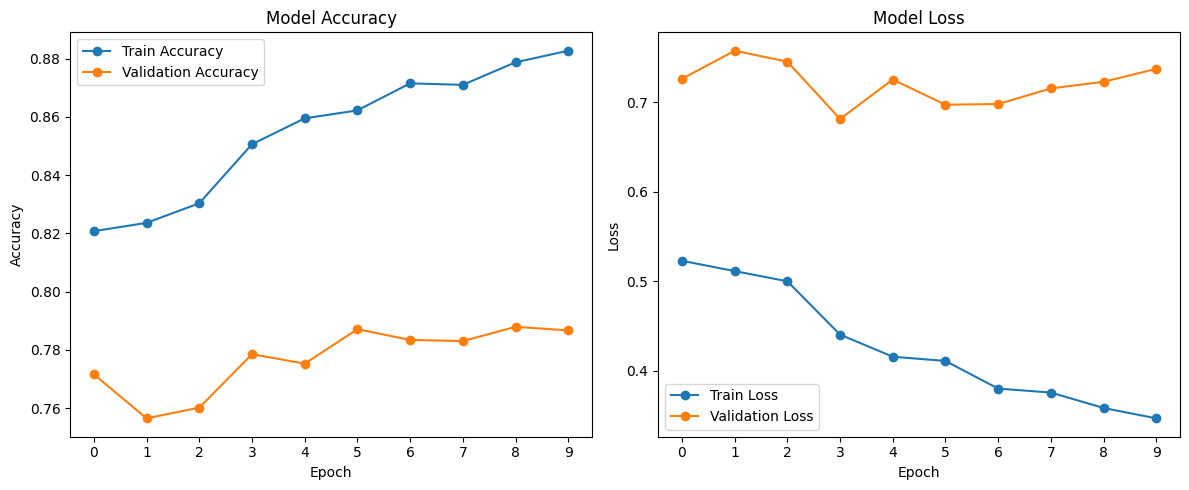

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/RAF-DB/VGG19_RAF-DB_phase3.keras


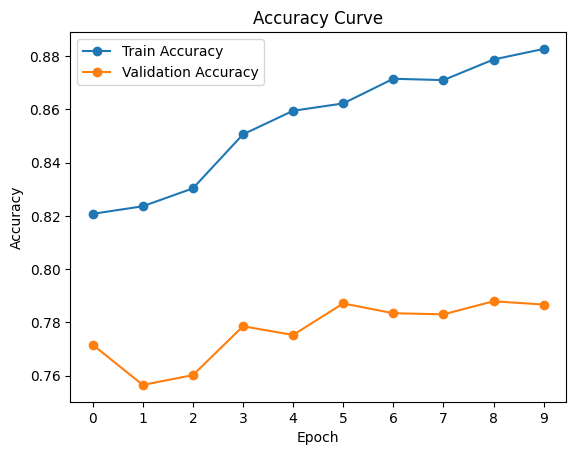

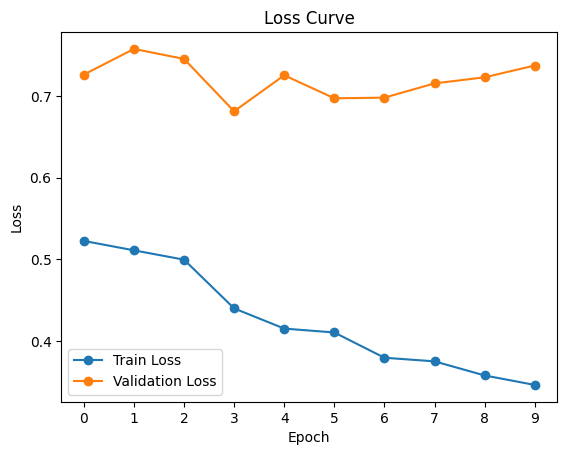

In [ ]:
# phase 3
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/VGG19_RAF-DB_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:7]:  #  7 | block3_conv1
    layer.trainable = False
for layer in model.layers[7:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_RAF-DB_" + phase + ".keras")

#FER 2013

    use phase 3 best

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download msambare/fer2013
!unzip /content/fer2013.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating: train/sad/Training_65526454.

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_FER2013_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_FER2013_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 7
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FER2013"

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 445s 597ms/step - accuracy: 0.2284 - loss: 1.9114 - val_accuracy: 0.3602 - val_loss: 1.6234
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 402s 560ms/step - accuracy: 0.3767 - loss: 1.5703 - val_accuracy: 0.4539 - val_loss: 1.4495
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 437s 554ms/step - accuracy: 0.4663 - loss: 1.3954 - val_accuracy: 0.5027 - val_loss: 1.2920
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 405s 563ms/step - accuracy: 0.5134 - loss: 1.2907 - val_accuracy: 0.5393 - val_loss: 1.2392
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 409s 570ms/step - accuracy: 0.5480 - loss: 1.2033 - val_accuracy: 0.5509 - val_loss: 1.1939


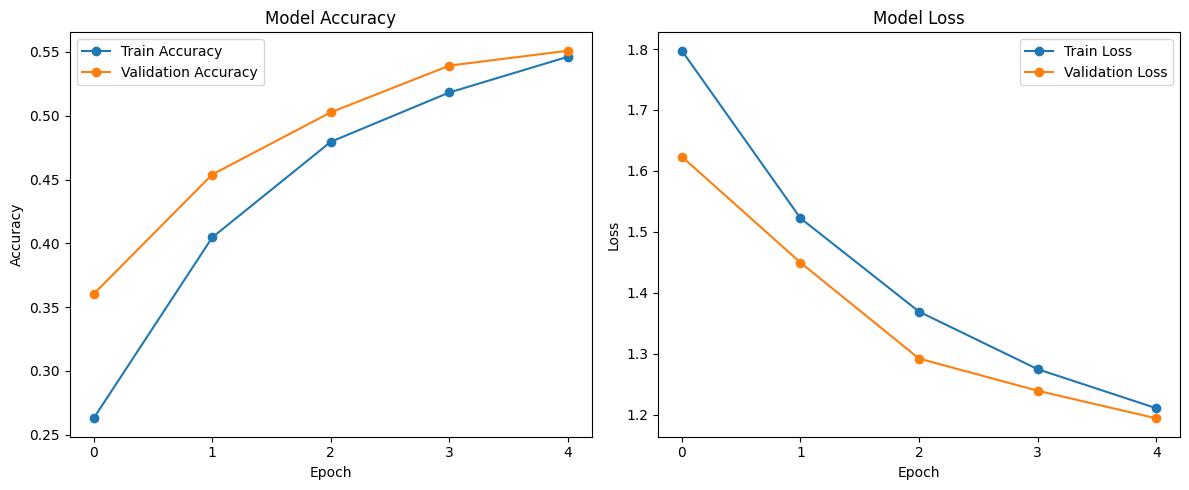

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FER2013/VGG19_FER2013_phase1.keras


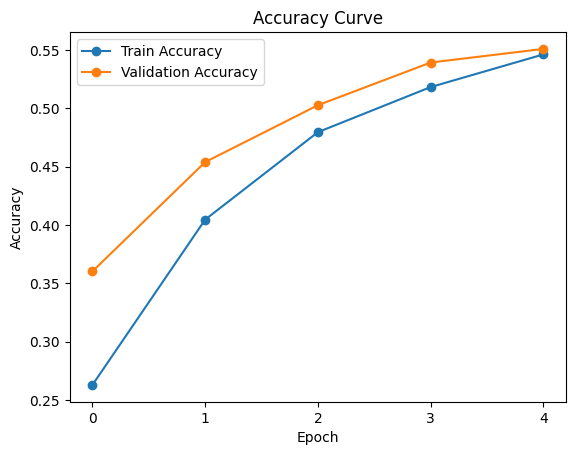

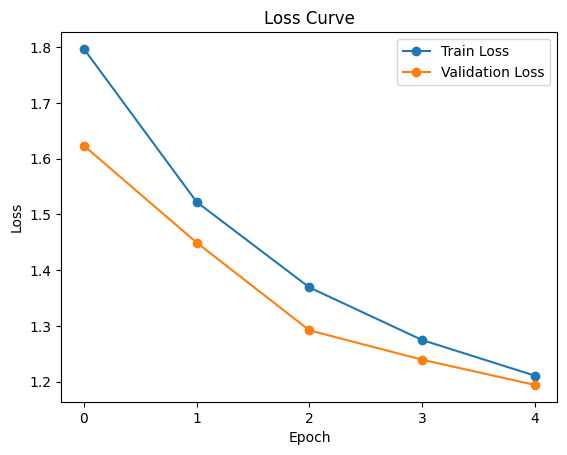

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:17]: # 17 | block5_conv1
    layer.trainable = False
for layer in base_model.layers[17:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_FER2013_" + phase + ".keras")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 473s 629ms/step - accuracy: 0.5840 - loss: 1.1142 - val_accuracy: 0.5762 - val_loss: 1.1312 - learning_rate: 1.0000e-05
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 431s 600ms/step - accuracy: 0.5964 - loss: 1.0898 - val_accuracy: 0.5792 - val_loss: 1.1202 - learning_rate: 1.0000e-05
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 431s 600ms/step - accuracy: 0.6025 - loss: 1.0544 - val_accuracy: 0.5865 - val_loss: 1.0960 - learning_rate: 1.0000e-05
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 428s 596ms/step - accuracy: 0.6067 - loss: 1.0492 - val_accuracy: 0.5903 - val_loss: 1.0937 - learning_rate: 1.0000e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 440s 592ms/step - accuracy: 0.6250 - loss: 1.0099 - val_accuracy: 0.6016 - val_loss: 1.0791 - learning_rate: 1.0000e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 428s 596ms/step - accuracy: 0.6273 - loss: 0.9943 - val_accuracy: 0.5969 - val_loss: 1.0859 - learning_rate: 1.0000e-05
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 

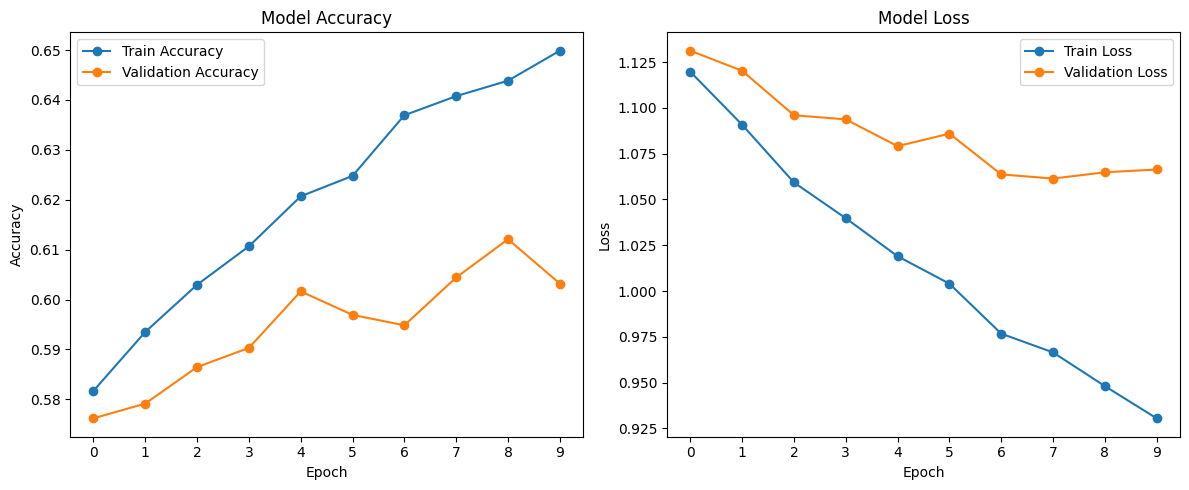

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FER2013/VGG19_FER2013_phase2.keras


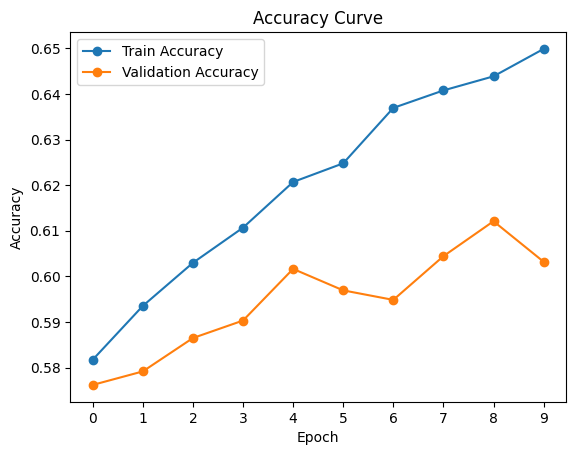

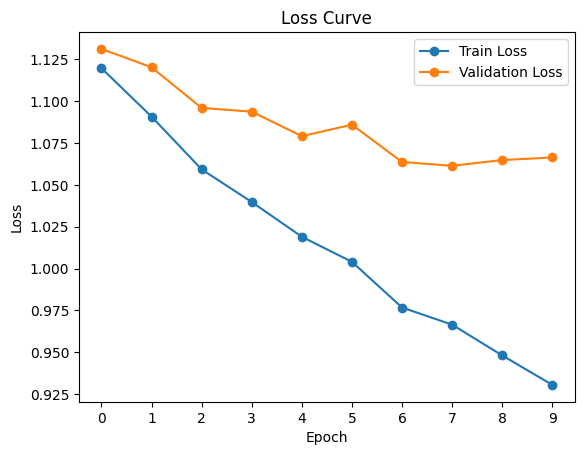

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/VGG19_FER2013_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:12]:  # 12 | block4_conv1
    layer.trainable = False
for layer in model.layers[12:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_FER2013_" + phase + ".keras")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 588s 781ms/step - accuracy: 0.6612 - loss: 0.9058 - val_accuracy: 0.6173 - val_loss: 1.0462 - learning_rate: 5.0000e-06
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 517s 666ms/step - accuracy: 0.6746 - loss: 0.8691 - val_accuracy: 0.6058 - val_loss: 1.0534 - learning_rate: 5.0000e-06
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6710 - loss: 0.8745
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
718/718 ━━━━━━━━━━━━━━━━━━━━ 467s 651ms/step - accuracy: 0.6710 - loss: 0.8745 - val_accuracy: 0.6088 - val_loss: 1.0551 - learning_rate: 5.0000e-06
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 451s 628ms/step - accuracy: 0.6837 - loss: 0.8490 - val_accuracy: 0.6189 - val_loss: 1.0410 - learning_rate: 2.5000e-06
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 447s 622ms/step - accuracy: 0.6854 - loss: 0.8457 - val_accuracy: 0.6140 - val_loss: 1.0549 - learning_rate: 2.5000e-06
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 550m

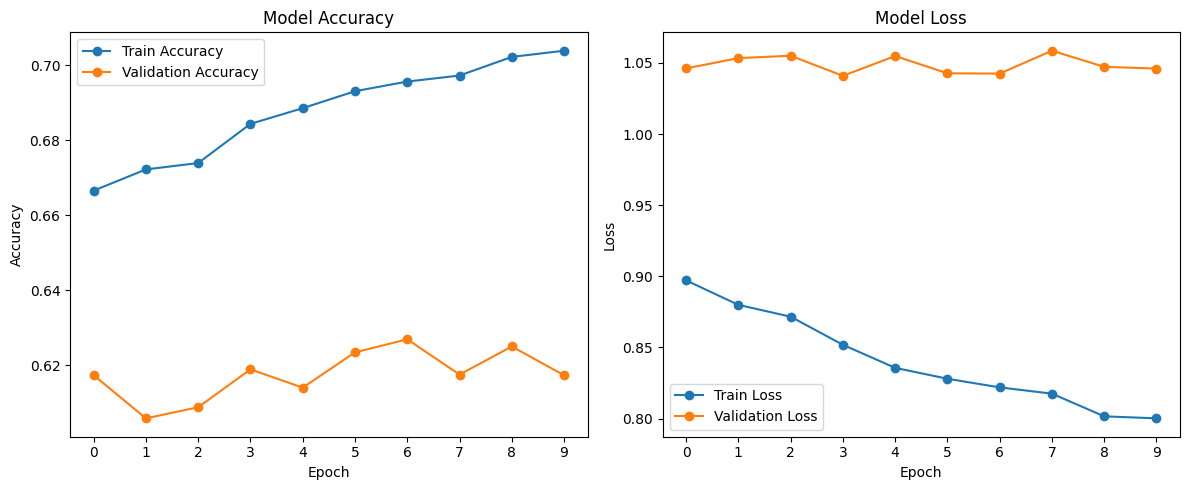

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FER2013/VGG19_FER2013_phase3.keras


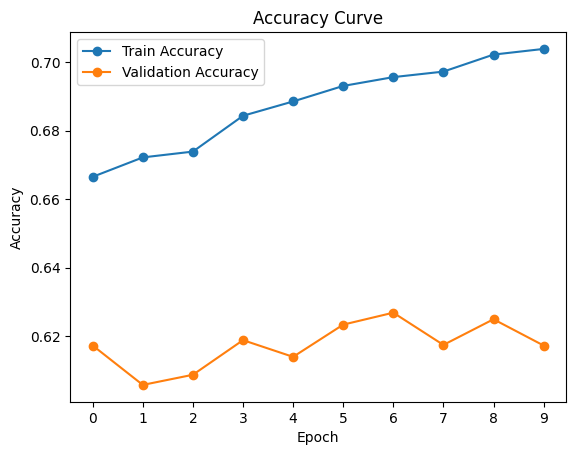

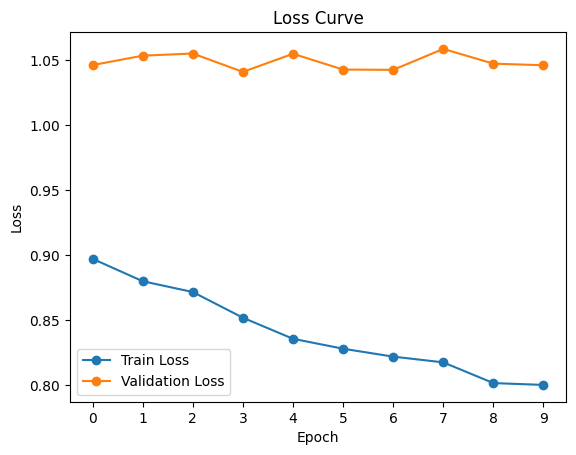

In [ ]:
# phase 3
lr = 5e-6
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/VGG19_FER2013_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:7]:
    layer.trainable = False
for layer in model.layers[7:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_FER2013_" + phase + ".keras")

# 新增區段

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Trainable params:", np.sum([np.prod(v.shape) for v in base_model.trainable_weights]))

base_model.trainable = False
#base_model.trainable = False
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

Trainable params: 23534592
  0 | input_layer_2                            | trainable = False
  1 | conv1_pad                                | trainable = False
  2 | conv1_conv                               | trainable = False
  3 | conv1_bn                                 | trainable = False
  4 | conv1_relu                               | trainable = False
  5 | pool1_pad                                | trainable = False
  6 | pool1_pool                               | trainable = False
  7 | conv2_block1_1_conv                      | trainable = False
  8 | conv2_block1_1_bn                        | trainable = False
  9 | conv2_block1_1_relu                      | trainable = False
 10 | conv2_block1_2_conv                      | trainable = False
 11 | conv2_block1_2_bn                        | trainable = False
 12 | conv2_block1_2_relu                      | trainable = False
 13 | conv2_block1_0_conv                      | trainable = False
 14 | conv2_block1_3_conv          

In [ ]:
model = build_model_with_head(base_model, 7)
for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

  0 | input_layer_2                            | trainable = False
  1 | conv1_pad                                | trainable = False
  2 | conv1_conv                               | trainable = False
  3 | conv1_bn                                 | trainable = False
  4 | conv1_relu                               | trainable = False
  5 | pool1_pad                                | trainable = False
  6 | pool1_pool                               | trainable = False
  7 | conv2_block1_1_conv                      | trainable = False
  8 | conv2_block1_1_bn                        | trainable = False
  9 | conv2_block1_1_relu                      | trainable = False
 10 | conv2_block1_2_conv                      | trainable = False
 11 | conv2_block1_2_bn                        | trainable = False
 12 | conv2_block1_2_relu                      | trainable = False
 13 | conv2_block1_0_conv                      | trainable = False
 14 | conv2_block1_3_conv                      | trainable = F

In [ ]:
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True


for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

  0 | input_layer_2                            | trainable = False
  1 | conv1_pad                                | trainable = False
  2 | conv1_conv                               | trainable = False
  3 | conv1_bn                                 | trainable = False
  4 | conv1_relu                               | trainable = False
  5 | pool1_pad                                | trainable = False
  6 | pool1_pool                               | trainable = False
  7 | conv2_block1_1_conv                      | trainable = False
  8 | conv2_block1_1_bn                        | trainable = False
  9 | conv2_block1_1_relu                      | trainable = False
 10 | conv2_block1_2_conv                      | trainable = False
 11 | conv2_block1_2_bn                        | trainable = False
 12 | conv2_block1_2_relu                      | trainable = False
 13 | conv2_block1_0_conv                      | trainable = False
 14 | conv2_block1_3_conv                      | trainable = F